# Compare Inference models for Protein Contacts using DCA
The purpose of this python notebook is to concisely compare several inferences models which all use Direct Coupling Analysis (DCA) to infer contact information for Multiple Sequence Alignments (MSA) of homologous protein families.

### Methods
* Mean Field (mfDCA)
* Pseudoliklihood (plmDCA)
* Expectation Reflection (erDCA)

In [1]:
import ecc_tools as tools
import numpy as np
import pandas as pd
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
#import emachine as EM
from direct_info import direct_info
from direct_info import sort_di
import data_processing as dp

import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt
%matplotlib inline

import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import expectation_reflection as ER
from direct_info import direct_info
from joblib import Parallel, delayed

# import inference_dca for mfDCA
from inference_dca import direct_info_dca

# import pydca for plmDCA
from pydca.plmdca import plmdca
from pydca.meanfield_dca import meanfield_dca
from pydca.sequence_backmapper import sequence_backmapper
from pydca.msa_trimmer import msa_trimmer
from pydca.contact_visualizer import contact_visualizer
from pydca.dca_utilities import dca_utilities

tools.hide_toggle()

## Read In Protein Structure

In [2]:
# Read in Protein structure
data_path = '../Pfam-A.full'
pfam_id = 'PF00186'
pfam_id = 'PF04542'
pfam_id = "PF00011"


pdb = np.load('%s/%s/pdb_refs.npy'%(data_path,pfam_id))

# Pre-Process Structure Data
# delete 'b' in front of letters (python 2 --> python 3)
pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0]) \
         for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])

# Print number of pdb structures in Protein ID folder
npdb = pdb.shape[0]
print('number of pdb structures:',npdb)

# Create pandas dataframe for protein structure
df = pd.DataFrame(pdb,columns = ['PF','seq','id','uniprot_start','uniprot_start',\
                                 'pdb_id','chain','pdb_start','pdb_end'])
print(df.head())

ipdb = 0
print('seq:',int(pdb[ipdb,1]))



# Read in Sequence Data
processing = True
if processing:
    # data processing
    s0,cols_removed,s_index,s_ipdb = dp.data_processing(data_path,pfam_id,ipdb,\
                    gap_seqs=0.2,gap_cols=0.2,prob_low=0.004,conserved_cols=0.9)
    # Save processed data
    msa_outfile, ref_outfile = dp.write_FASTA(s0,pfam_id,s_ipdb)
else:
    msa_outfile, ref_outfile = dp.create_unprocessed_FASTA(pdb,data_path,pfam_id,ipdb)
    
    # create MSATrimmer instance 
    trimmer = msa_trimmer.MSATrimmer(
        msa_outfile, biomolecule='protein', 
        refseq_file=ref_outfile,
    )

    trimmed_data = trimmer.get_msa_trimmed_by_refseq(remove_all_gaps=True)
    print ("trimmed_data:\n",trimmed_data)

    #write trimmed msa to file in FASTA format
    trimmed_data_outfile = 'MSA_'+pfam_id+'_Trimmed.fa'
    with open(trimmed_data_outfile, 'w') as fh:
        for seqid, seq in trimmed_data:
            fh.write('>{}\n{}\n'.format(seqid, seq))
            
            
#----------------CGCUUCAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAG-CCUUAAA-CUCUUGAUUAUGAAGUG-------------
#CGCUUCAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUGAAGUG
#UGAAAUUGGAUAACAGUUUUUCGUAUAAUCUCGGGAAU-UGGCCUGAGAGUUUCUACGAGAUCACCGCAAAUGAUCUGGCUACGAAAAAAAGGAACGGUAUC
tools.hide_toggle()



number of pdb structures: 100
        PF   seq           id uniprot_start uniprot_start pdb_id chain  \
0  PF00011  1834  HS16B_WHEAT            47           150   2BYU     L   
1  PF00011  1834  HS16B_WHEAT            47           150   2BYU     D   
2  PF00011  1834  HS16B_WHEAT            47           150   2BYU     G   
3  PF00011  1834  HS16B_WHEAT            47           150   2BYU     B   
4  PF00011  1834  HS16B_WHEAT            47           150   2BYU     A   

  pdb_start pdb_end  
0        47     150  
1        47     150  
2        47     150  
3        47     150  
4        47     150  
seq: 1834
tpdb is now  1513




## Expectation Reflection DCA (erDCA)
* Generate One-Hot matrix representation of sequence data
* Generate and plot Contact Map

Structure exists: '/home/eclay/DCA_ER/by/pdb2byu.ent' 
(92, 3)


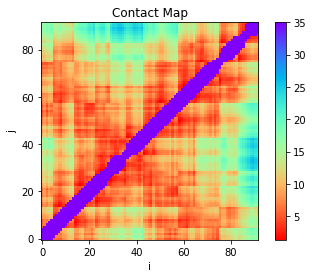

In [3]:
# number of positions
n_var = s0.shape[1]

# number of aminoacids at each position
mx = np.array([len(np.unique(s0[:,i])) for i in range(n_var)])

mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T 

# number of variables
mx_sum = mx.sum()

# number of bias term
n_linear = mx_sum - n_var

#---------------------- Generate One-Hot/Contact -------------------#
# Generate One-Hot Matrix
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
# s is OneHot encoder format, s0 is original sequnce matrix
s = onehot_encoder.fit_transform(s0)

# Generate Contact Map
ct = tools.contact_map(pdb,ipdb,cols_removed,s_index)
ct_distal = tools.distance_restr(ct,s_index,make_large=True)
#--------------------------------------------------------------------#

plt.title('Contact Map')
plt.imshow(ct_distal,cmap='rainbow_r',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.colorbar(fraction=0.045, pad=0.05)
plt.show()

tools.hide_toggle()

#### Apply Expectation Reflection

In [4]:
# Define wight matrix with variable for each possible amino acid at each sequence position
w = np.zeros((mx.sum(),mx.sum())) 
h0 = np.zeros(mx.sum())

In [5]:
# Expectation Reflection
#=========================================================================================
def predict_w(s,i0,i1i2,niter_max,l2):
    #print('i0:',i0)
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    x = np.hstack([s[:,:i1],s[:,i2:]])
    y = s[:,i1:i2]

    h01,w1 = ER.fit(x,y,niter_max,l2)

    return h01,w1

#-------------------------------
# parallel
start_time = timeit.default_timer()
res = Parallel(n_jobs = 32)(delayed(predict_w)\
        (s,i0,i1i2,niter_max=10,l2=100.0)\
        for i0 in range(n_var))

run_time = timeit.default_timer() - start_time
print('ER run time:',run_time)

#-------------------------------

for i0 in range(n_var):
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    h01 = res[i0][0]
    w1 = res[i0][1]

    h0[i1:i2] = h01
    w[:i1,i1:i2] = w1[:i1,:]
    w[i2:,i1:i2] = w1[i1:,:]

# make w symmetric
w = (w + w.T)/2.

tools.hide_toggle()

ER run time: 397.84062245098175


#### Calculate Direct Info from erDCA

In [6]:
#print(w[:10,-10:])
di_er = direct_info(s0,w)
#sorted_DI_er = sorted_DI_er[::2]
sorted_DI_ER_redundant = sort_di(di_er)
print("Print top 10 pairs")
for x in sorted_DI_ER_redundant[:10]:
    print(x)

from data_processing import delete_sorted_DI_duplicates # newly generated for this python notebook.
sorted_DI_er = delete_sorted_DI_duplicates(sorted_DI_ER_redundant)

sorted_DI_er_dr = tools.distance_restr_sortedDI(sorted_DI_er)

print("\nPrint top 10 Non-Redundant pairs")
for x in sorted_DI_er[:10]:
    print(x)

Print top 10 pairs
((91, 90), 0.2310022268178999)
((90, 91), 0.2310022268178999)
((87, 86), 0.20026051744602086)
((86, 87), 0.20026051744602086)
((89, 90), 0.18468412365206874)
((90, 89), 0.18468412365206874)
((32, 53), 0.15005327201879962)
((53, 32), 0.15005327201879962)
((89, 88), 0.14106721304656503)
((88, 89), 0.14106721304656503)

Print top 10 Non-Redundant pairs
((91, 90), 0.2310022268178999)
((87, 86), 0.20026051744602086)
((89, 90), 0.18468412365206874)
((32, 53), 0.15005327201879962)
((89, 88), 0.14106721304656503)
((48, 47), 0.13995235777739007)
((0, 1), 0.1301749050974569)
((88, 87), 0.12504659150875427)
((47, 55), 0.12458855671164065)
((19, 11), 0.12026218641265621)


## Mean Field DCA (mfDCA)

In [7]:

#create mean-field DCA instance 
mfdca_inst = meanfield_dca.MeanFieldDCA(
    msa_outfile,
    'protein',
    pseudocount = 0.5,
    seqid = 0.8,

)

#start_time = timeit.default_timer()
#di_mf = direct_info_dca(s0)
#run_time = timeit.default_timer() - start_time
#print('MF run time:',run_time)

# Compute DCA scores using Mean Field DCA
start_time = timeit.default_timer()
sorted_DI_mf = mfdca_inst.compute_sorted_DI()
run_time = timeit.default_timer() - start_time
print('MF run time:',run_time)

N = mfdca_inst.sequences_len
B = mfdca_inst.num_sequences
print("sorted_DI (list) has shape: ",np.array(sorted_DI_mf).shape,"\nRows: all combinations of sequence postitions ie sequence len choose 2 ")
print("num sequences = %d , sequences len = %d\n\n"%(B,N))



print("Print top 10 pairs")
for site_pair, score in sorted_DI_mf[:10]:
    print(site_pair, score)

print("\nPrint top 10 pairs (Distance Restraint)")
sorted_DI_mf_dr = tools.distance_restr_sortedDI(sorted_DI_mf)
for site_pair, score in sorted_DI_mf_dr[:10]:
    print(site_pair, score)
    
# Generate Direct Information matrix
di_mf = np.zeros((N,N))
DI_ver= np.array(sorted_DI_mf)

for coupling in sorted_DI_mf:
    di_mf[coupling[0][0],coupling[0][1]] = coupling[1]
    di_mf[coupling[0][1],coupling[0][0]] = coupling[1]

print("Calculated DI: (shape, matrix)\n",di_mf.shape,"\n",di_mf)
np.save("mfDCA_DI_%s.npy"%(pfam_id),di_mf)


tools.hide_toggle()

MF run time: 20.86252656200668
sorted_DI (list) has shape:  (4186, 2) 
Rows: all combinations of sequence postitions ie sequence len choose 2 
num sequences = 18023 , sequences len = 92


Print top 10 pairs
(47, 55) 0.2093494285901497
(47, 48) 0.17285767760044907
(86, 87) 0.1560871633308812
(32, 53) 0.15412734120436986
(0, 81) 0.1406935601311321
(90, 91) 0.12140751689885385
(10, 48) 0.11998011733286434
(11, 19) 0.11730771104872266
(12, 13) 0.11539068116739021
(87, 88) 0.11471249788126729

Print top 10 pairs (Distance Restraint)
(47, 55) 0.2093494285901497
(32, 53) 0.15412734120436986
(0, 81) 0.1406935601311321
(10, 48) 0.11998011733286434
(11, 19) 0.11730771104872266
(27, 58) 0.08032167051781947
(12, 70) 0.07465877799850745
(13, 70) 0.07105144917702759
(4, 78) 0.06938205323210155
(32, 51) 0.06741126738534761
Calculated DI: (shape, matrix)
 (92, 92) 
 [[0.         0.07582571 0.0641272  ... 0.00100515 0.00252749 0.00257624]
 [0.07582571 0.         0.05208704 ... 0.00285497 0.00134775 0.0

## Pseudoliklihood DCA (plmDCA)

In [8]:
# DCA scores using Pseudolikelihood maximization algorithm        
plmdca_inst = plmdca.PlmDCA(
    msa_outfile,
    'protein',
    seqid = 0.8,
    lambda_h = 1.0,
    lambda_J = 20.0,
    num_threads = 10,
    max_iterations = 500,
)

# Compute DCA scores using Pseudolikelihood maximization algorithm
start_time = timeit.default_timer()
sorted_DI_plm = plmdca_inst.compute_sorted_DI()
run_time = timeit.default_timer() - start_time
print('PLM run time:',run_time)

N = plmdca_inst.sequences_len
B = plmdca_inst.num_sequences
print("sorted_DI (list) has shape: ",np.array(sorted_DI_plm).shape,"\nRows: all combinations of sequence postitions ie sequence len choose 2 ")
print("num sequences = %d , sequences len = %d\n\n"%(B,N))

print("Print top 10 pairs")
for site_pair, score in sorted_DI_plm[:10]:
    print(site_pair, score)

print("\nPrint top 10 pairs (Distance Restraint)")
sorted_DI_plm_dr = tools.restr_sortedDI(sorted_DI_plm)
for site_pair, score in sorted_DI_mf_plm[:10]:
    print(site_pair, score)
    
tools.hide_toggle()

PLM run time: 398.25439437897876
sorted_DI (list) has shape:  (4186, 2) 
Rows: all combinations of sequence postitions ie sequence len choose 2 
num sequences = 18987 , sequences len = 92


Print top 10 pairs
(15, 17) 0.0559562275560817
(32, 53) 0.05432551229429072
(47, 55) 0.04996552424276757
(0, 81) 0.049788605547757325
(10, 48) 0.049592554648394696
(64, 67) 0.048647410468389586
(33, 35) 0.04185646053281306
(4, 78) 0.040148415820674736
(20, 89) 0.0396326575009838
(73, 74) 0.03417039350884262

Print top 10 pairs (Distance Restraint)


AttributeError: module 'ecc_tools' has no attribute 'restr_sortedDI'

In [ ]:
# Generate Direct Information matrix
di_plm = np.zeros((N,N))
DI_ver= np.array(sorted_DI_plm)


for coupling in sorted_DI_er:
    di_plm[coupling[0][0],coupling[0][1]] = coupling[1]
    di_plm[coupling[0][1],coupling[0][0]] = coupling[1]
print("Calculated DI: (shape, matrix)\n",di_plm.shape,"\n",di_plm)
np.save("plmDCA_DI_%s.npy"%(pfam_id),di_plm)

## Plot ROC, AUC, and Precision for all Methods
* Vary contact threshold for each method to find optimal contact prediction for each model
* Plot resulting ROC, AUC, and Precision

In [ ]:
# DCA_di = direct_info_dca(s0)
# #sorted_DI_er = sorted_DI_er[::2]
# sorted_DI_mf = sort_di(DCA_di)
# print("Print top 10 pairs")
# for site_pair, score in sorted_DI_mf[:10]:
#     print(site_pair, score)

In [ ]:
print("di_er shape = ",di_er.shape)
print("di_mf shape = ",di_mf.shape)
print("di_plm shape = ",di_plm.shape)

plt.subplot2grid((1,3),(0,0))
plt.title('(ER)')
plt.imshow(di_er,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)
plt.subplot2grid((1,3),(0,1))
plt.title('(MF)')
plt.imshow(di_mf,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)
plt.subplot2grid((1,3),(0,2))
plt.title('(PLM)')
plt.imshow(di_plm,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)
plt.show()

distance_enforced = True
if distance_enforced:
    #di_er_dr = tools.distance_restr(di_er,s_index,make_large=False)
    #di_mf_dr = tools.distance_restr(di_mf,s_index,make_large=False)
    #di_plm_dr = tools.distance_restr(di_plm,s_index,make_large=False)
    for coupling in sorted_DI_er_dr:
        di_er_dr[coupling[0][0],coupling[0][1]] = coupling[1]
        di_er_dr[coupling[0][1],coupling[0][0]] = coupling[1]
    for coupling in sorted_DI_mf_dr:
        di_mf_dr[coupling[0][0],coupling[0][1]] = coupling[1]
        di_mf_dr[coupling[0][1],coupling[0][0]] = coupling[1]
    for coupling in sorted_DI_plm_dr:
        di_plm_dr[coupling[0][0],coupling[0][1]] = coupling[1]
        di_plm_dr[coupling[0][1],coupling[0][0]] = coupling[1]
        

plt.subplot2grid((1,3),(0,0))
plt.title('(ER)')
plt.imshow(di_er_dr,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)
plt.subplot2grid((1,3),(0,1))
plt.title('(MF)')
plt.imshow(di_mf_dr,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)
plt.subplot2grid((1,3),(0,2))
plt.title('(PLM)')
plt.imshow(di_plm_dr,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)
plt.show()

# find optimal threshold of distance for both DCA and ER
ct_thres = np.linspace(1.5,10.,18,endpoint=True)
n = ct_thres.shape[0]

auc_mf = np.zeros(n)
auc_er = np.zeros(n)
auc_plm = np.zeros(n)

for i in range(n):
    p,tp,fp = tools.roc_curve(ct_distal,di_mf_dr,ct_thres[i])
    auc_mf[i] = tp.sum()/tp.shape[0]
    
    p,tp,fp = tools.roc_curve(ct_distal,di_er_dr,ct_thres[i])
    auc_er[i] = tp.sum()/tp.shape[0]
    
    p,tp,fp = tools.roc_curve(ct_distal,di_plm,ct_thres[i])
    auc_plm[i] = tp.sum()/tp.shape[0]
    
i0_mf = np.argmax(auc_mf)
i0_er = np.argmax(auc_er)
i0_plm = np.argmax(auc_plm)


p0_mf,tp0_mf,fp0_mf = tools.roc_curve(ct_distal,di_mf_dr,ct_thres[i0_mf])
p0_er,tp0_er,fp0_er = tools.roc_curve(ct_distal,di_er_dr,ct_thres[i0_er])
p0_plm,tp0_plm,fp0_plm = tools.roc_curve(ct_distal,di_plm,ct_thres[i0_plm])

tools.hide_toggle()

In [ ]:
# Plot ROC for optimal DCA vs optimal ER
print("Optimal Contact threshold for (mf, er, plm) = (%f, %f, %f)"%(ct_thres[i0_mf],ct_thres[i0_er],ct_thres[i0_plm]))
print("Maximal AUC for (mf, er, plm) = (%f, %f, %f)"%(auc_mf[i0_mf], auc_er[i0_er], auc_plm[i0_plm]))


plt.subplot2grid((1,3),(0,0))
plt.title('ROC ')
plt.plot(fp0_er,tp0_er,'b-',label="er")
plt.plot(fp0_mf,tp0_mf,'r-',label="mf")
plt.plot(fp0_plm,tp0_plm,'g-',label="plm")
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Plot AUC for DCA and ER
plt.subplot2grid((1,3),(0,1))
plt.title('AUC')
plt.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
plt.plot(ct_thres,auc_er,'b-',label="er")
plt.plot(ct_thres,auc_mf,'r-',label="mf")
plt.plot(ct_thres,auc_plm,'g-',label="plm")
plt.ylim([min(auc_er.min(),auc_mf.min(),auc_plm.min())-0.05,max(auc_er.max(),auc_mf.max(),auc_plm.max())+0.05])
plt.xlim([ct_thres.min(),ct_thres.max()])
plt.xlabel('distance threshold')
plt.ylabel('AUC')
plt.legend()

# Plot Precision of optimal DCA and ER
plt.subplot2grid((1,3),(0,2))
plt.title('Precision')
plt.plot( p0_er,tp0_er / (tp0_er + fp0_er),'b-',label='er')
plt.plot( p0_mf,tp0_mf / (tp0_mf + fp0_mf),'r-',label='mf')
plt.plot( p0_plm,tp0_plm / (tp0_plm + fp0_plm),'g-',label='plm')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
#plt.ylim([0,1])
plt.ylim([.4,.8])
plt.xlabel('Recall (Sensitivity - P)')
plt.ylabel('Precision (PPV)')
plt.legend()

plt.tight_layout(h_pad=1, w_pad=1.5)


tools.hide_toggle()

In [ ]:
# Using PYDCA contact mapping module
print("Dimensions of DI Pairs:")
print("ER: ",len(sorted_DI_er))
print("PLM: ",len(sorted_DI_plm))
print("MF: ",len(sorted_DI_mf))


erdca_visualizer = contact_visualizer.DCAVisualizer('protein', pdb[ipdb,6], pdb[ipdb,5],
    refseq_file = ref_outfile,
    sorted_dca_scores = sorted_DI_er,
    linear_dist = 4,
    contact_dist = 8.0,
)

mfdca_visualizer = contact_visualizer.DCAVisualizer('protein', pdb[ipdb,6], pdb[ipdb,5],
    refseq_file = ref_outfile,
    sorted_dca_scores = sorted_DI_mf,
    linear_dist = 4,
    contact_dist = 8.0,
)

plmdca_visualizer = contact_visualizer.DCAVisualizer('protein', pdb[ipdb,6], pdb[ipdb,5],
    refseq_file = ref_outfile,
    sorted_dca_scores = sorted_DI_plm,
    linear_dist = 4,
    contact_dist = 8.0,
)

er_contact_map_data = erdca_visualizer.plot_contact_map()
mf_contact_map_data = mfdca_visualizer.plot_contact_map()
plm_contact_map_data = plmdca_visualizer.plot_contact_map()

er_tp_rate_data = erdca_visualizer.plot_true_positive_rates()
mf_tp_rate_data = mfdca_visualizer.plot_true_positive_rates()
plm_tp_rate_data = plmdca_visualizer.plot_true_positive_rates()